In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


In [4]:
file_path = "default of credit card clients.xls"
df = pd.read_excel(file_path, skiprows=1)

In [5]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [6]:
#Remove NaN values - Drop rows with any NaN values
df = df.dropna()

In [7]:
#fill NaN values based on data type or specific columns
for column in df.columns:
    if df[column].dtype == "object":  # If it's a categorical column
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:  # For numerical columns
        df[column].fillna(df[column].median(), inplace=True)

<ipython-input-7-50373002e4a9>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)


In [8]:
#Remove duplicate rows
df = df.drop_duplicates()

In [9]:
#Standardize column names (lowercase and replace spaces with underscores for consistency)
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [10]:
print(df.columns)
# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment_next_month'],
      dtype='object')


In [11]:
# Remove rows where all bill and payment amounts are zero
bill_cols = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
pay_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

df = df[~((df[bill_cols].sum(axis=1) == 0) & (df[pay_cols].sum(axis=1) == 0))]

In [12]:
# Handle outliers in 'LIMIT_BAL', BILL_AMT*, and PAY_AMT*
q_low = df["limit_bal"].quantile(0.01)
q_high = df["limit_bal"].quantile(0.99)
df = df[(df["limit_bal"] >= q_low) & (df["limit_bal"] <= q_high)]

for column in bill_cols:
    q_low = df[column].quantile(0.01)
    q_high = df[column].quantile(0.99)
    df = df[(df[column] >= q_low) & (df[column] <= q_high)]

for column in pay_cols:
    q_low = df[column].quantile(0.01)
    q_high = df[column].quantile(0.99)
    df = df[(df[column] >= q_low) & (df[column] <= q_high)]

In [13]:
df['sex'] = df['sex'].astype('category')
df['education'] = df['education'].astype('category')
df['marriage'] = df['marriage'].astype('category')

In [14]:
df = pd.get_dummies(df, columns=['sex', 'education', 'marriage'], drop_first=True)
df = df.drop(columns=['id'])


In [15]:
# Identify numerical columns for scaling
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Initialize scaler
scaler = StandardScaler()

# Apply scaling
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

X = 0 # Explanatory variables
y = 0 # response variable

In [16]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 24223 entries, 0 to 29999
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   24223 non-null  float64
 1   age                         24223 non-null  float64
 2   pay_0                       24223 non-null  float64
 3   pay_2                       24223 non-null  float64
 4   pay_3                       24223 non-null  float64
 5   pay_4                       24223 non-null  float64
 6   pay_5                       24223 non-null  float64
 7   pay_6                       24223 non-null  float64
 8   bill_amt1                   24223 non-null  float64
 9   bill_amt2                   24223 non-null  float64
 10  bill_amt3                   24223 non-null  float64
 11  bill_amt4                   24223 non-null  float64
 12  bill_amt5                   24223 non-null  float64
 13  bill_amt6                   24223 no

In [29]:
# Logistic Regression Implementation
X = df.drop(columns=['default_payment_next_month'])
y = df['default_payment_next_month']
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Using SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Uncomment this line to use SMOTE-augmentated dataset, comment to use original dataset
X_train, y_train = X_train_resampled, y_train_resampled

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred_lr = model.predict(X_test)
y_pred_prob_lr = model.predict_proba(X_test)

print("\nLogistic Regression Metrics:")
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_prob_lr[:,1])

print("Accuracy:", accuracy_lr)
print("ROC-AUC Score:", roc_auc_lr)

print("Classification Report:\n", classification_report(y_test, y_pred_lr))



Logistic Regression Metrics:
Accuracy: 0.7397825787807899
ROC-AUC Score: 0.7274223500052622
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.83      5663
           1       0.43      0.56      0.49      1604

    accuracy                           0.74      7267
   macro avg       0.65      0.68      0.66      7267
weighted avg       0.77      0.74      0.75      7267



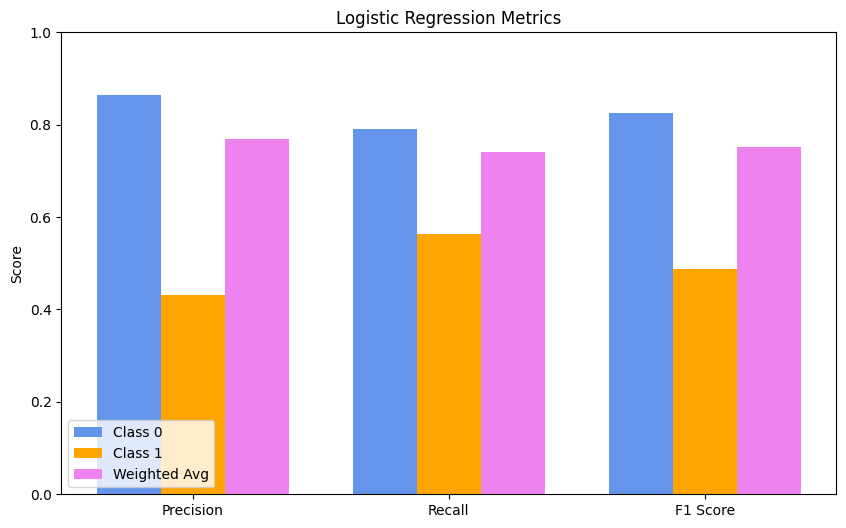

In [30]:
# Logistic Regression Classification Report Visualization
report = classification_report(y_test, y_pred_lr, output_dict=True)
precision_0 = report['0']['precision']
recall_0 = report['0']['recall']
f1_0 = report['0']['f1-score']

precision_1 = report['1']['precision']
recall_1 = report['1']['recall']
f1_1 = report['1']['f1-score']

precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_weighted = report['weighted avg']['f1-score']

# Metrics and values for the grouped bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values_0 = [precision_0, recall_0, f1_0]
values_1 = [precision_1, recall_1, f1_1]
values_weighted = [precision_weighted, recall_weighted, f1_weighted]

# Create the grouped bar chart
x = np.arange(len(metrics))  # the label locations
width = 0.25  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width, values_0, width, label='Class 0', color='cornflowerblue')
plt.bar(x, values_1, width, label='Class 1', color='orange')
plt.bar(x + width, values_weighted, width, label='Weighted Avg', color='violet')

plt.ylabel('Score')
plt.title('Logistic Regression Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend(loc='lower left')

plt.show()


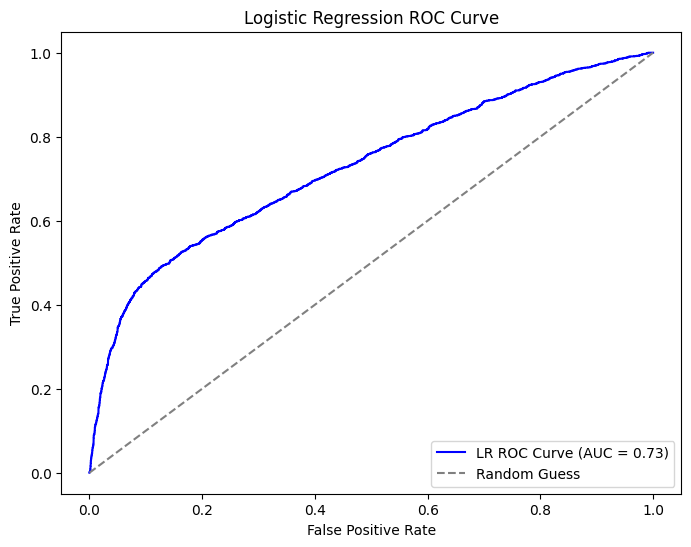

In [31]:
#ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'LR ROC Curve (AUC = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [32]:
# Gradient Boosting Implementation
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
y_pred_prob_gb = gb_model.predict_proba(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_pred_prob_gb[:, 1])

print("\nGradient Boosting Metrics:")
print("Accuracy:", accuracy_gb)
print("ROC-AUC Score:", roc_auc_gb)

print("Classification Report:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Metrics:
Accuracy: 0.8096876290078436
ROC-AUC Score: 0.7664785370143421
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      5663
           1       0.58      0.50      0.54      1604

    accuracy                           0.81      7267
   macro avg       0.72      0.70      0.71      7267
weighted avg       0.80      0.81      0.80      7267



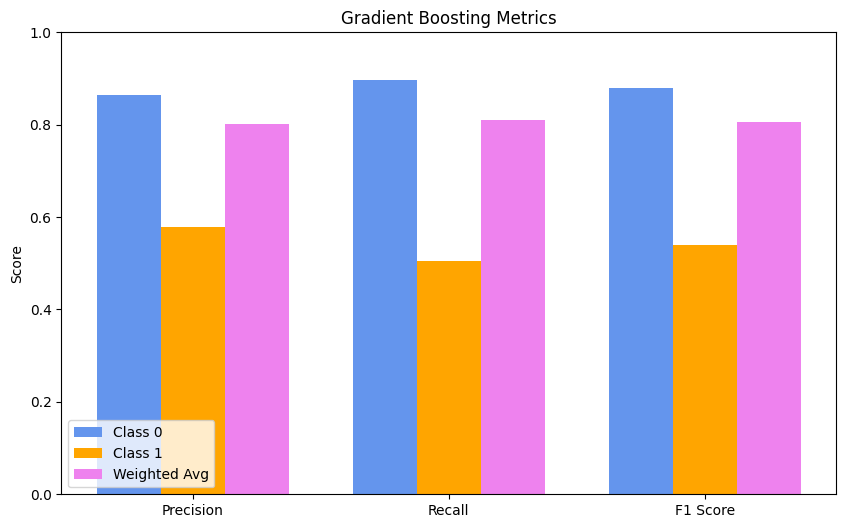

In [33]:
# Gradient Boosting Classification Report Visualization
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)
precision_0 = report_gb['0']['precision']
recall_0 = report_gb['0']['recall']
f1_0 = report_gb['0']['f1-score']

precision_1 = report_gb['1']['precision']
recall_1 = report_gb['1']['recall']
f1_1 = report_gb['1']['f1-score']

precision_weighted = report_gb['weighted avg']['precision']
recall_weighted = report_gb['weighted avg']['recall']
f1_weighted = report_gb['weighted avg']['f1-score']

# Metrics and values for the grouped bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values_0_gb = [precision_0, recall_0, f1_0]
values_1_gb = [precision_1, recall_1, f1_1]
values_weighted_gb = [precision_weighted, recall_weighted, f1_weighted]

# Create the grouped bar chart
x = np.arange(len(metrics))  # the label locations
width = 0.25  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width, values_0_gb, width, label='Class 0', color='cornflowerblue')
plt.bar(x, values_1_gb, width, label='Class 1', color='orange')
plt.bar(x + width, values_weighted_gb, width, label='Weighted Avg', color='violet')

plt.ylabel('Score')
plt.title('Gradient Boosting Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend(loc='lower left')

plt.show()
values_weighted_gb = values_weighted_gb.append(accuracy_gb)

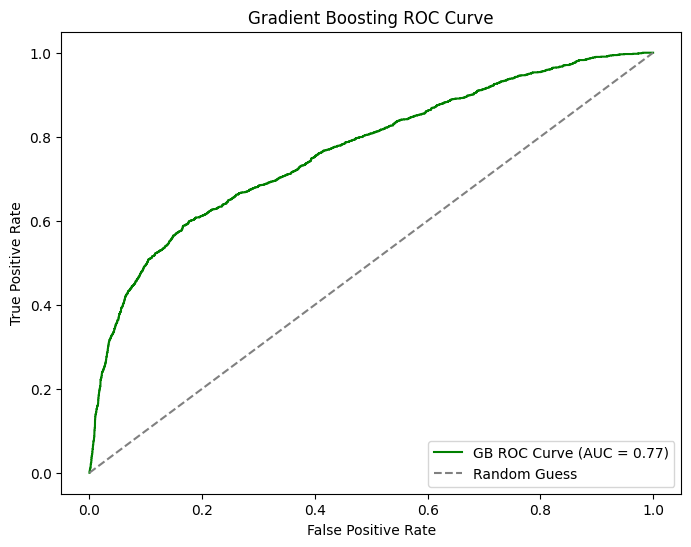

In [34]:
#ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gb[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f'GB ROC Curve (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [35]:
# Random Forest Implementation
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf[:, 1])

print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_rf)
print("ROC-AUC Score:", roc_auc_rf)

print("Classification Report:\n", classification_report(y_test, y_pred_rf))



Random Forest Metrics:
Accuracy: 0.8041832943442961
ROC-AUC Score: 0.7649868684284344
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      5663
           1       0.56      0.49      0.53      1604

    accuracy                           0.80      7267
   macro avg       0.71      0.69      0.70      7267
weighted avg       0.80      0.80      0.80      7267



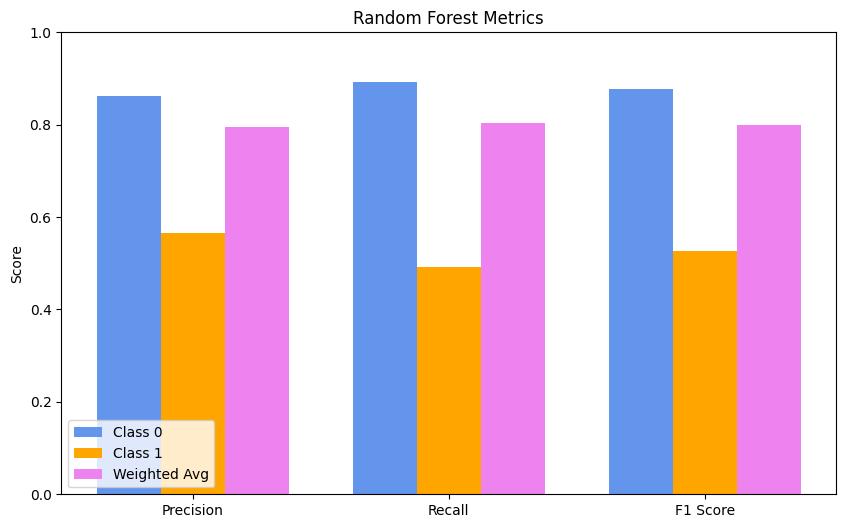

In [36]:
# Random Forest Classification Report Visualization
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
precision_0 = report_rf['0']['precision']
recall_0 = report_rf['0']['recall']
f1_0 = report_rf['0']['f1-score']

precision_1 = report_rf['1']['precision']
recall_1 = report_rf['1']['recall']
f1_1 = report_rf['1']['f1-score']

precision_weighted = report_rf['weighted avg']['precision']
recall_weighted = report_rf['weighted avg']['recall']
f1_weighted = report_rf['weighted avg']['f1-score']

# Metrics and values for the grouped bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values_0_rf = [precision_0, recall_0, f1_0]
values_1_rf = [precision_1, recall_1, f1_1]
values_weighted_rf = [precision_weighted, recall_weighted, f1_weighted]

# Create the grouped bar chart
x = np.arange(len(metrics))  # the label locations
width = 0.25  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width, values_0_rf, width, label='Class 0', color='cornflowerblue')
plt.bar(x, values_1_rf, width, label='Class 1', color='orange')
plt.bar(x + width, values_weighted_rf, width, label='Weighted Avg', color='violet')

plt.ylabel('Score')
plt.title('Random Forest Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend(loc='lower left')

plt.show()

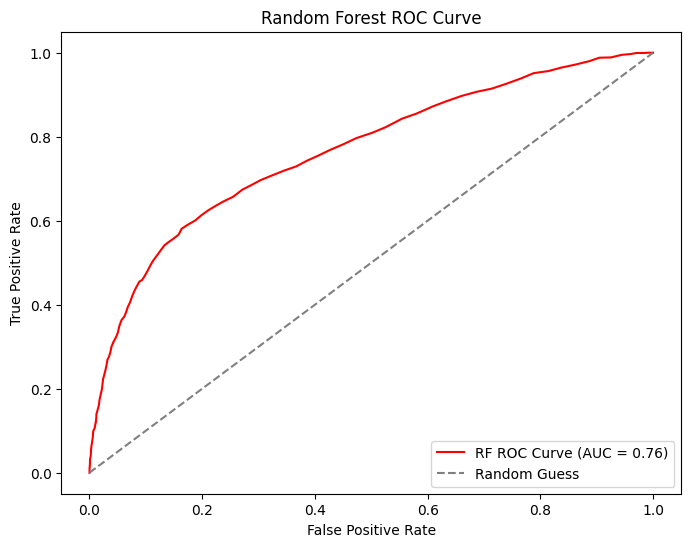

In [37]:
#ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'RF ROC Curve (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()

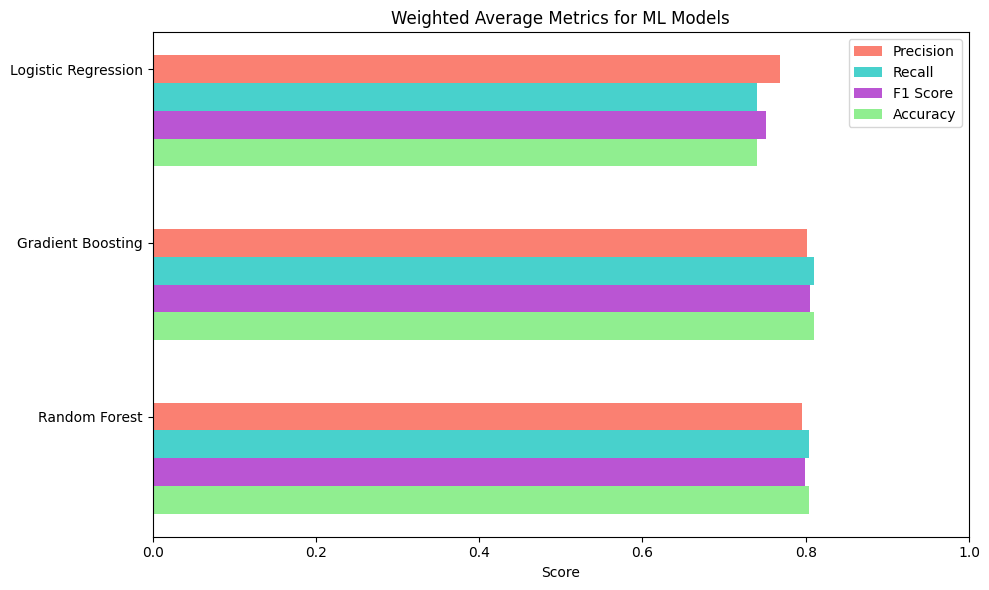

In [38]:
# Combined metrics visualization
models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
metrics = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
colors = ['salmon', 'mediumturquoise', 'mediumorchid', 'lightgreen']  # Custom colors for the metrics

# Get data from models
# LR data
report_lr = classification_report(y_test, y_pred_lr, output_dict=True)
precision_weighted = report_lr['weighted avg']['precision']
recall_weighted = report_lr['weighted avg']['recall']
f1_weighted = report_lr['weighted avg']['f1-score']
values_weighted_lr = [precision_weighted, recall_weighted, f1_weighted, accuracy_lr]

# GB data
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)
precision_weighted = report_gb['weighted avg']['precision']
recall_weighted = report_gb['weighted avg']['recall']
f1_weighted = report_gb['weighted avg']['f1-score']
values_weighted_gb = [precision_weighted, recall_weighted, f1_weighted, accuracy_gb]

# RF data
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
precision_weighted = report_rf['weighted avg']['precision']
recall_weighted = report_rf['weighted avg']['recall']
f1_weighted = report_rf['weighted avg']['f1-score']
values_weighted_rf = [precision_weighted, recall_weighted, f1_weighted, accuracy_rf]


data = np.array([values_weighted_rf, values_weighted_gb, values_weighted_lr])

# Set up the bar chart
y = np.arange(len(models)) * 1.25  # Space out models on the y-axis
width = 0.2  # Bar width

plt.figure(figsize=(10, 6))

# Plot each metric in the specified order
for i, (metric, color) in enumerate(zip(metrics, colors)):
    plt.barh(
        y - (i) * width,  # Offset positions for each metric
        data[:, i],  # Data for the current metric across all models
        width,
        label=metric,
        color=color
    )

# Customization
plt.xlabel('Score')
plt.title('Weighted Average Metrics for ML Models')
plt.yticks(y, models)  # Y-axis labels as models with added spacing
plt.xlim(0, 1)  # Score range between 0 and 1
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


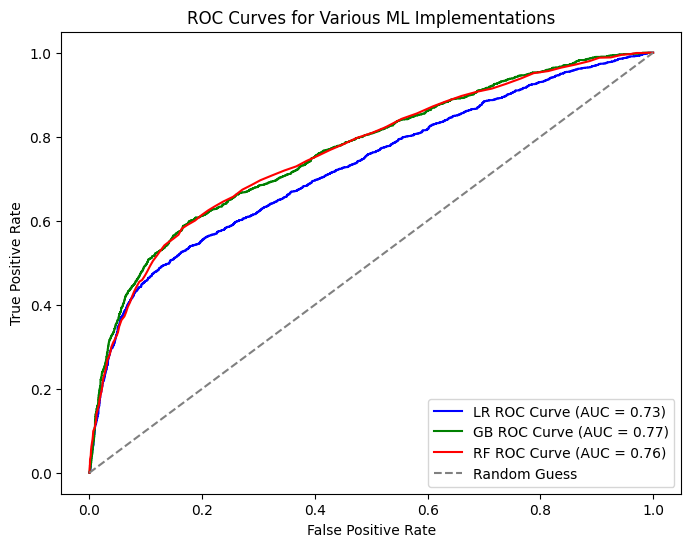

In [39]:
# Combined ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lr[:, 1])
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_pred_prob_gb[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf[:, 1])

# Plot ROC curves
plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='blue', label=f'LR ROC Curve (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_gb, tpr_gb, color='green', label=f'GB ROC Curve (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_rf, tpr_rf, color='red', label=f'RF ROC Curve (AUC = {roc_auc_rf:.2f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


plt.title('ROC Curves for Various ML Implementations')
plt.legend(loc='lower right')
plt.show()